<a href="https://colab.research.google.com/github/AIinComputerVision/EVA4/blob/master/EVA4S6_withL2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#import all the libraries
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-6.0, 6.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [38]:
len(test_loader)

79

In [0]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]           4,608
              ReLU-6           [-1, 32, 24, 24]               0
       BatchNorm2d-7           [-1, 32, 24, 24]              64
           Dropout-8           [-1, 32, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             320
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,440
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1

In [0]:
from tqdm import tqdm

train_losses = []
validation_losses = []
train_acc = []
validation_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    validation_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            validation_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    validation_loss /= len(test_loader.dataset)
    validation_losses.append(validation_loss)

    print('\nvalidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        validation_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    validation_acc.append(100. * correct / len(test_loader.dataset))

In [8]:
#L2 is added as weight decay parameter
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=0.000001)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.10532615333795547 Batch_id=468 Accuracy=87.14: 100%|██████████| 469/469 [00:13<00:00, 35.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0677, Accuracy: 9812/10000 (98.12%)

EPOCH: 1


Loss=0.11560849100351334 Batch_id=468 Accuracy=97.70: 100%|██████████| 469/469 [00:12<00:00, 36.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0567, Accuracy: 9826/10000 (98.26%)

EPOCH: 2


Loss=0.045773763209581375 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:13<00:00, 36.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0358, Accuracy: 9896/10000 (98.96%)

EPOCH: 3


Loss=0.015136058442294598 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:13<00:00, 36.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0296, Accuracy: 9914/10000 (99.14%)

EPOCH: 4


Loss=0.06958726048469543 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:12<00:00, 36.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0312, Accuracy: 9902/10000 (99.02%)

EPOCH: 5


Loss=0.01832021214067936 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:12<00:00, 37.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0261, Accuracy: 9923/10000 (99.23%)

EPOCH: 6


Loss=0.08023945242166519 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:13<00:00, 35.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0229, Accuracy: 9929/10000 (99.29%)

EPOCH: 7


Loss=0.05287819728255272 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:12<00:00, 36.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0240, Accuracy: 9917/10000 (99.17%)

EPOCH: 8


Loss=0.054846856743097305 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:12<00:00, 36.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0204, Accuracy: 9931/10000 (99.31%)

EPOCH: 9


Loss=0.03951403498649597 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:12<00:00, 37.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0214, Accuracy: 9926/10000 (99.26%)

EPOCH: 10


Loss=0.06581556051969528 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:13<00:00, 34.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0227, Accuracy: 9923/10000 (99.23%)

EPOCH: 11


Loss=0.0047243437729775906 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:12<00:00, 36.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0206, Accuracy: 9930/10000 (99.30%)

EPOCH: 12


Loss=0.017403090372681618 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:12<00:00, 37.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0199, Accuracy: 9939/10000 (99.39%)

EPOCH: 13


Loss=0.04444384574890137 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:13<00:00, 34.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0172, Accuracy: 9948/10000 (99.48%)

EPOCH: 14


Loss=0.024125821888446808 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:13<00:00, 34.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0207, Accuracy: 9935/10000 (99.35%)

EPOCH: 15


Loss=0.004004433751106262 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:12<00:00, 36.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0180, Accuracy: 9938/10000 (99.38%)

EPOCH: 16


Loss=0.02243322692811489 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:12<00:00, 37.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0190, Accuracy: 9939/10000 (99.39%)

EPOCH: 17


Loss=0.020058125257492065 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:12<00:00, 36.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0197, Accuracy: 9936/10000 (99.36%)

EPOCH: 18


Loss=0.0053908973932266235 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:13<00:00, 34.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0196, Accuracy: 9944/10000 (99.44%)

EPOCH: 19


Loss=0.016451409086585045 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:13<00:00, 36.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0175, Accuracy: 9945/10000 (99.45%)

EPOCH: 20


Loss=0.026529664173722267 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:12<00:00, 37.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0196, Accuracy: 9936/10000 (99.36%)

EPOCH: 21


Loss=0.05686501786112785 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:12<00:00, 36.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0193, Accuracy: 9947/10000 (99.47%)

EPOCH: 22


Loss=0.00576348602771759 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:13<00:00, 35.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0170, Accuracy: 9941/10000 (99.41%)

EPOCH: 23


Loss=0.008897597901523113 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:12<00:00, 36.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0179, Accuracy: 9944/10000 (99.44%)

EPOCH: 24


Loss=0.0017029395094141364 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:12<00:00, 43.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0179, Accuracy: 9949/10000 (99.49%)

EPOCH: 25


Loss=0.025386394932866096 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:13<00:00, 35.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0182, Accuracy: 9939/10000 (99.39%)

EPOCH: 26


Loss=0.03331584855914116 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:12<00:00, 37.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0189, Accuracy: 9946/10000 (99.46%)

EPOCH: 27


Loss=0.03175381198525429 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:12<00:00, 36.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0158, Accuracy: 9955/10000 (99.55%)

EPOCH: 28


Loss=0.003438423154875636 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:12<00:00, 36.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0162, Accuracy: 9949/10000 (99.49%)

EPOCH: 29


Loss=0.04149119555950165 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:12<00:00, 36.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0173, Accuracy: 9949/10000 (99.49%)

EPOCH: 30


Loss=0.03800386190414429 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:12<00:00, 42.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0179, Accuracy: 9937/10000 (99.37%)

EPOCH: 31


Loss=0.03810761123895645 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:13<00:00, 33.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0171, Accuracy: 9948/10000 (99.48%)

EPOCH: 32


Loss=0.005469411611557007 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:12<00:00, 37.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0174, Accuracy: 9943/10000 (99.43%)

EPOCH: 33


Loss=0.008889500983059406 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:12<00:00, 36.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0163, Accuracy: 9949/10000 (99.49%)

EPOCH: 34


Loss=0.023720121011137962 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:12<00:00, 37.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0157, Accuracy: 9955/10000 (99.55%)

EPOCH: 35


Loss=0.011399050243198872 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:13<00:00, 35.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0177, Accuracy: 9946/10000 (99.46%)

EPOCH: 36


Loss=0.005306810140609741 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:12<00:00, 36.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0151, Accuracy: 9948/10000 (99.48%)

EPOCH: 37


Loss=0.02869497798383236 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:12<00:00, 37.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0183, Accuracy: 9945/10000 (99.45%)

EPOCH: 38


Loss=0.021437034010887146 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:12<00:00, 36.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


validation set: Average loss: 0.0162, Accuracy: 9951/10000 (99.51%)

EPOCH: 39


Loss=0.019930055364966393 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:13<00:00, 35.05it/s]



validation set: Average loss: 0.0177, Accuracy: 9936/10000 (99.36%)



Text(0, 0.5, 'accuracy in percentage')

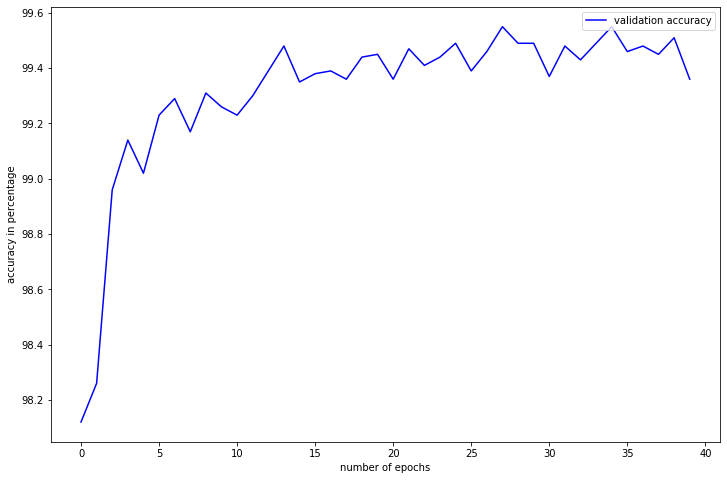

In [23]:
fig0 = plt.figure(figsize=(12,8))
plt.plot(validation_acc, color='blue')
plt.legend(['validation accuracy'], loc='upper right')
plt.xlabel('number of epochs')
plt.ylabel('accuracy in percentage')


Text(0, 0.5, 'negative log likelihood loss')

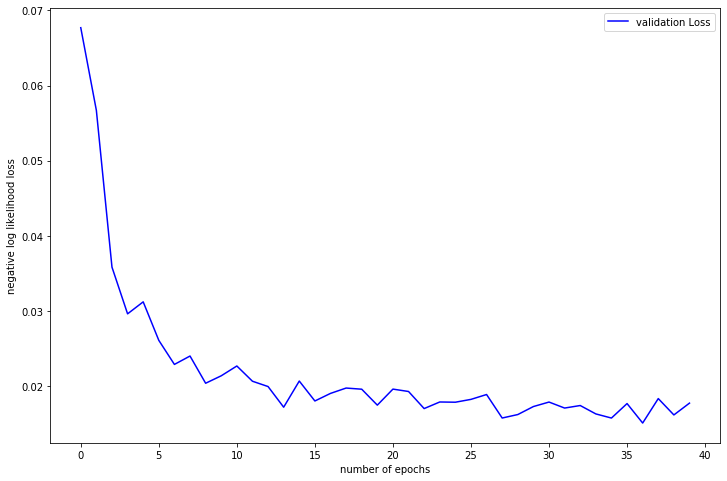

In [24]:
fig1 = plt.figure(figsize=(12,8))
plt.plot(validation_losses, color='blue')
plt.legend(['validation Loss'], loc='upper right')
plt.xlabel('number of epochs')
plt.ylabel('negative log likelihood loss')


In [0]:
with torch.no_grad():
  output = network(example_data)

In [0]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

In [41]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([128, 1, 28, 28])

In [0]:
with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

In [40]:
len(output)

16

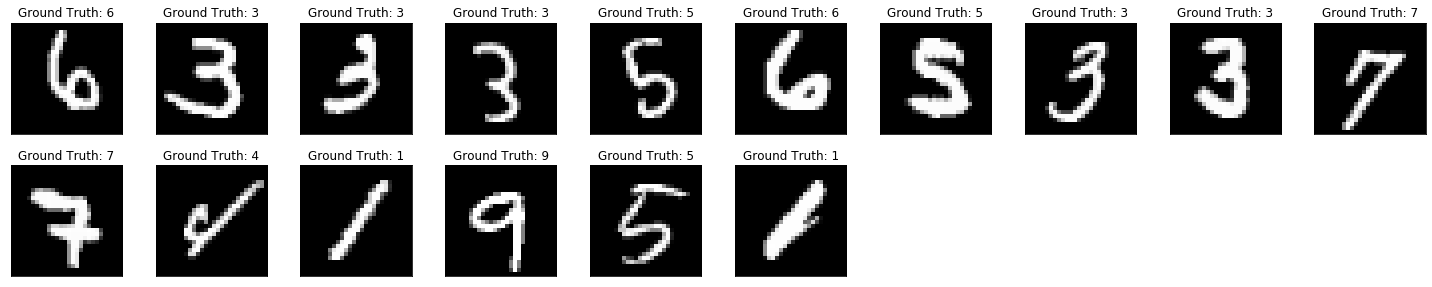

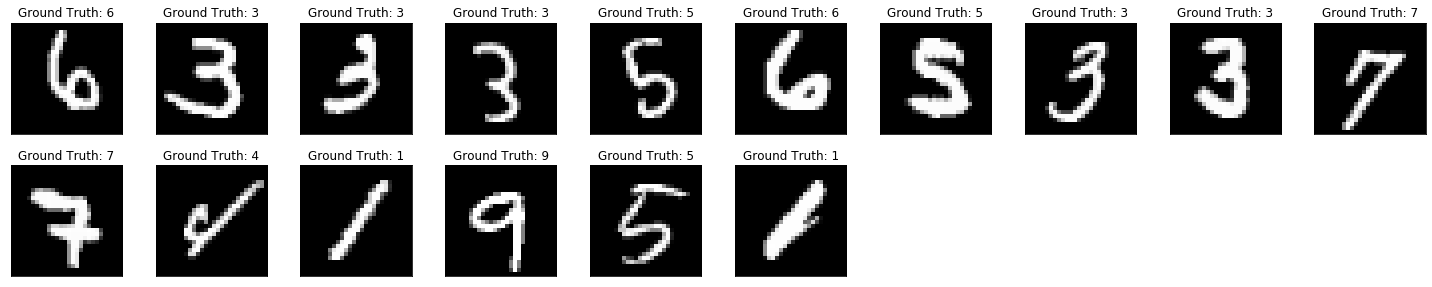

In [43]:
fig = plt.figure(figsize=(20,10))
for i in range(16):
  plt.subplot(5,10,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [0]:
for example_data, example_targets in test_loader:
            data, target = example_data.to(device), example_targets.to(device)
            output = model(data)

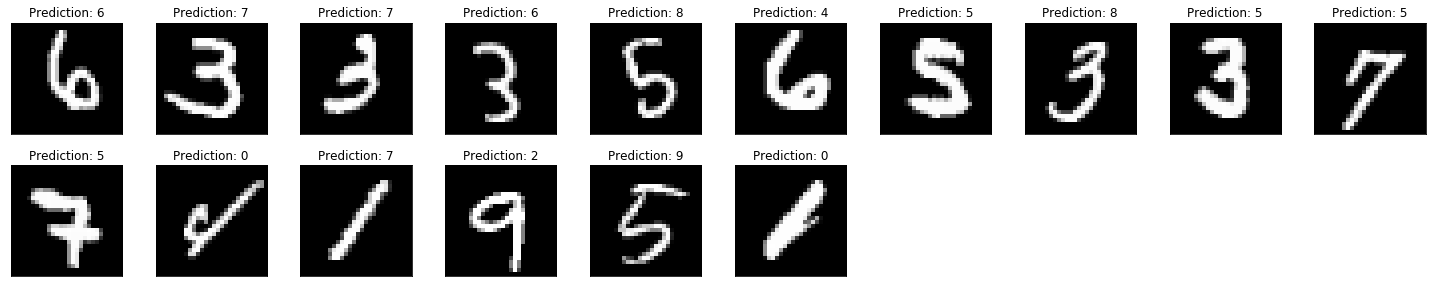

In [42]:
fig = plt.figure(figsize=(20,10))
for i in range(16):
  plt.subplot(5,10,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])